In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py
import json
from matplotlib import pyplot as plt
import torch 
from torch import nn
from torchinfo import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

In [2]:
# hdf5_file = h5py.File("/kaggle/input/radioml2018/GOLD_XYZ_OSC.0001_1024.hdf5",  'r')
# modulation_classes = json.load(open("/kaggle/input/radioml2018/classes-fixed.json", 'r'))
# data = hdf5_file['X']
# modulation = np.argmax(hdf5_file['Y'], axis=1)
# snr = hdf5_file['Z'][:, 0]

In [3]:
n_channels=2
batch_size=32
# Number of frames per snr/modulation combination for train,valid and test data
nf_train = 1024
nf_valid = 512
nf_test = 256

In [4]:
def dataset_split(data,
                   modulations_classes,
                   modulations,snrs,
                   target_modulations,
                   mode,
                   target_snrs,train_proportion=0.7,
                   valid_proportion=0.2,
                   test_proportion=0.1,
                   seed=48):
    np.random.seed(seed)
    train_split_index = int(train_proportion*4096)
    valid_split_index = int((valid_proportion+train_proportion)*4096)
    test_split_index = int((test_proportion+valid_proportion+train_proportion)*4096)
    X_output=[]
    Y_output=[]
    Z_output=[]

    target_modulation_indices = [modulations_classes.index(modu) for modu in target_modulations]
    
    for modu in  target_modulation_indices:       
        for snr in target_snrs:
            snr_modu_indices = np.where((modulations==modu) & (snrs==snr))[0]

            np.random.shuffle(snr_modu_indices)
            train, valid, test, remaining = np.split(snr_modu_indices, [train_split_index,valid_split_index,test_split_index])
            if mode=='train':
                X_output.append(data[np.sort(train)])
                Y_output.append(modulations[np.sort(train)])
                Z_output.append(snrs[np.sort(train)])
            elif mode=='valid':
                X_output.append(data[np.sort(valid)])
                Y_output.append(modulations[np.sort(valid)])
                Z_output.append(snrs[np.sort(valid)])
            elif mode =='test':
                X_output.append(data[np.sort(test)])
                Y_output.append(modulations[np.sort(test)])
                Z_output.append(snrs[np.sort(test)])
            else:
                raise ValueError(f'unknown mode: {mode}. Valid modes are train, valid and test') 
    X_array = np.vstack(X_output)
    Y_array = np.concatenate(Y_output)
    Z_array = np.concatenate(Z_output)
    for index,value in enumerate(np.unique(np.copy(Y_array))):
        Y_array[Y_array==value]=index
    return X_array, Y_array, Z_array

In [5]:
class RadioML18Dataset(Dataset):
    def __init__(self, mode: str,seed=48,):
        super(RadioML18Dataset, self).__init__()
        
        # load data
        hdf5_file = h5py.File("/kaggle/input/radioml2018/GOLD_XYZ_OSC.0001_1024.hdf5",  'r')
        self.modulation_classes = json.load(open("/kaggle/input/radioml2018/classes-fixed.json", 'r'))
        self.X = hdf5_file['X']
        self.Y = np.argmax(hdf5_file['Y'], axis=1)
        self.Z = hdf5_file['Z'][:, 0]
        
        train_proportion=(24*26*nf_train)/self.X.shape[0]
        valid_proportion=(24*26*nf_valid)/self.X.shape[0]
        test_proportion=(24*26*nf_test)/self.X.shape[0]
        
#         target_modulations =['OOK', '4ASK', 'BPSK', 'QPSK', '8PSK',
# '16QAM', 'AM-SSB-SC', 'AM-DSB-SC', 'FM', 'GMSK',
# 'OQPSK']
        
        # Target modulation class and snr   
        self.target_modulations = ['OOK', '4ASK', 'BPSK']
        self.target_snrs = np.unique(self.Z)
        
        self.X_data, self.Y_data, self.Z_data = dataset_split(
                                                                  data = self.X,
                                                                  modulations_classes = self.modulation_classes,
                                                                  modulations = self.Y,
                                                                  snrs = self.Z,
                                                                  mode = mode,
                                                                  train_proportion = train_proportion,
                                                                  valid_proportion = valid_proportion,
                                                                  test_proportion = test_proportion,
                                                                  target_modulations = self.target_modulations,
                                                                  target_snrs  = self.target_snrs,
                                                                  seed=48
                                                                 )   

        # store statistic of whole dataset
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]
        
    def __len__(self):
        return self.X_data.shape[0]

    def __getitem__(self, idx):
        x,y,z = self.X_data[idx], self.Y_data[idx], self.Z_data[idx]
        x,y,z = torch.Tensor(x).transpose(0, 1) , y , z
        return x,y,z

In [6]:
ds = RadioML18Dataset(mode='test')
data_len = ds.num_data
n_labels=ds.num_lbl
n_snrs = ds.num_snr
frame_size=ds.X.shape[1]

del ds

In [7]:
# # Checking data if correctly stratified
# train_set = RadioML18Dataset(mode='train')
# valid_set = RadioML18Dataset(mode='valid')
# test_set = RadioML18Dataset(mode='test')
# mod=train_set.Y
# snrs=train_set.Z
# for modu in np.unique(train_set.Y):
#     for snr in np.unique(train_set.Z):  
#         t=np.where((mod[train_set.idx]==modu) & (snrs[train_set.idx]==snr))[0].shape[0]
#         v=np.where((mod[valid_set.idx]==modu) & (snrs[valid_set.idx]==snr))[0].shape[0]
#         ts=np.where((mod[test_set.idx]==modu) & (snrs[test_set.idx]==snr))[0].shape[0]
#         assert (t+v+ts)/(1024+512+256)==1.0,"data not stratified"
# del train_set,valid_set,test_set        

In [257]:
import time
st = time.time()
train_dl = DataLoader(dataset=RadioML18Dataset(mode='train'),batch_size=64, shuffle=True, drop_last=True)
valid_dl = DataLoader(dataset=RadioML18Dataset(mode='valid'),batch_size=128, shuffle=False, drop_last=False)
test_dl = DataLoader(dataset=RadioML18Dataset(mode='test'),batch_size=128, shuffle=False, drop_last=False)
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 6.647922515869141 seconds


In [9]:
class CNN_Block(nn.Module):
    def __init__(self,input_shape,output_shape):
        super().__init__()
        self.net=nn.Sequential(
        nn.Conv1d(input_shape, output_shape, kernel_size=3, padding=1),
        nn.BatchNorm1d(output_shape),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size= 2, stride= 2),
        nn.Dropout(0.25),
        )
        
    def forward(self,x):
        return self.net(x)
    
class CNN_NET(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone=nn.Sequential(
        CNN_Block(2,24),
        CNN_Block(24,24),
        CNN_Block(24,48),
        CNN_Block(48,48), 
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072,128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,n_labels)
        )
        
    def forward(self,x):
        return self.classifier(self.backbone(x))
    

In [10]:
summary(CNN_NET().to('cpu'), (batch_size,n_channels, frame_size))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_NET                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 48, 64]              --
│    └─CNN_Block: 2-1                    [32, 24, 512]             --
│    │    └─Sequential: 3-1              [32, 24, 512]             216
│    └─CNN_Block: 2-2                    [32, 24, 256]             --
│    │    └─Sequential: 3-2              [32, 24, 256]             1,800
│    └─CNN_Block: 2-3                    [32, 48, 128]             --
│    │    └─Sequential: 3-3              [32, 48, 128]             3,600
│    └─CNN_Block: 2-4                    [32, 48, 64]              --
│    │    └─Sequential: 3-4              [32, 48, 64]              7,056
├─Sequential: 1-2                        [32, 3]                   --
│    └─Flatten: 2-5                      [32, 3072]                --
│    └─Linear: 2-6                       [32, 128]                 393,344


In [75]:
def train_model(model,verbose=True,device='cuda',num_epoch=30):
    
    
    model.to(device)
    
    train_loss = torch.zeros(num_epoch)
    train_acc = torch.zeros(num_epoch)
    val_loss = torch.zeros(num_epoch)
    val_acc = torch.zeros(num_epoch)
    
    lr = 0.001
    optimizer = optim.Adam(list(model.parameters()), lr=lr)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer , 0.9 )
    criterion = nn.CrossEntropyLoss()
    
    
    for epoch in trange(num_epoch, unit='epochs'):    
        #Trainning phase
        model.train()
        for x,y,z in train_dl:
            # TODO
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss[epoch] += loss.detach().cpu()
            train_acc[epoch] += torch.mean((torch.argmax(logits.to('cpu'), dim=-1) == y.to('cpu')).float())
        #Evaluation phase
        model.eval()
        with torch.no_grad():
            for x,y,z in valid_dl:
                x = x.to(device)
                y = y.to(device)
                logits = model(x)
                loss = criterion(logits,y)
                val_loss[epoch] += loss.detach().cpu()
                val_acc[epoch] += torch.mean((torch.argmax(logits.to('cpu'), dim=-1) == y.to('cpu')).float())
        lr_scheduler.step()
        train_loss[epoch] /= (len(train_dl.dataset) // train_dl.batch_size)
        train_acc[epoch] /= (len(train_dl.dataset) // train_dl.batch_size)
        val_loss[epoch] /= (len(valid_dl.dataset)//valid_dl.batch_size)
        val_acc[epoch] /= (len(valid_dl.dataset)//valid_dl.batch_size)
        if verbose:
            tqdm.write('Epoch {} (train) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, train_loss[epoch], train_acc[epoch]))
            tqdm.write('Epoch {} (valid) -- loss: {:.4f} accuracy: {:.4f}'.format(epoch, val_loss[epoch], val_acc[epoch]))
    return model,[train_loss,train_acc,val_loss,val_acc]

In [13]:
def test_model(model,device='cuda'):
    test_accuracy = 0
    model.eval()
    Y_array_ = []
    Z_array_ = []
    target_classes = test_dl.dataset.target_modulations
    target_snrs = test_dl.dataset.target_snrs
    modulation_classes = test_dl.dataset.modulation_classes
    target_modulations_indices = [modulation_classes.index(mod) for mod in target_classes]
    
    accuracy_stats = pd.DataFrame(
        data=[np.zeros(len(target_snrs))]*len(target_classes),
        index=target_classes,
        columns=target_snrs.astype('str'))
    
    with torch.no_grad():
        for x,y,z in test_dl:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            Y_array_.append(y[torch.argmax(logits.to('cpu'), dim=-1) == y.to('cpu')])
            Z_array_.append(z[torch.argmax(logits.to('cpu'), dim=-1) == y.to('cpu')])
    
    Y_array = torch.cat(Y_array_).cpu().detach().numpy()  
    Z_array = torch.cat(Z_array_).cpu().detach().numpy()  
    
    total_accuracy = round(len(Y_array)*100/len(test_dl.dataset.Y_data),2)
    print(f'Accuracy on test dataset :{total_accuracy}%.')
    for index,value in enumerate(target_modulations_indices):
        Y_array[Y_array==index]=value  
    for modu in target_modulations_indices:
        for snr in target_snrs:
            counts = len(Y_array[(Y_array==modu) & (Z_array==snr)])
            accuracy_stats[str(snr)][modulation_classes[modu]] += counts

      
    
    ground_truth_modulations = np.copy(test_dl.dataset.Y_data)
    snrs = np.copy(test_dl.dataset.Z_data)    
    for index,value in enumerate(target_modulations_indices):
        ground_truth_modulations[ground_truth_modulations==index]=value     
    for modu in target_modulations_indices:
        for snr in target_snrs:

            counts = len(ground_truth_modulations[(ground_truth_modulations==modu) & (snrs==snr)])
            accuracy_stats[str(snr)][modulation_classes[modu]] = accuracy_stats[str(snr)][modulation_classes[modu]]*100/counts
            accuracy_stats[str(snr)][modulation_classes[modu]] = round(accuracy_stats[str(snr)][modulation_classes[modu]],2)
            
    return accuracy_stats

def plot_training_history(model_name:str,history:list):
    plt.title(f'Training of {model_name} model on radioml2018')
    plt.xlabel('Epochs')   
    plt.plot(history[0],label='train_loss')
    plt.plot(history[1],label='train_accuracy')
    plt.plot(history[2],label='valid_loss')
    plt.plot(history[3],label='valid_accuracy')
    plt.legend(loc="upper left")  
    plt.show()
    
def plot_test_accuracy(model,device='cuda'):
    accuracy_df = test_model(model)
    fig,axes = plt.subplots(len(test_dl.dataset.target_modulations),1,figsize=(12,8), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.4)
    fig.supylabel('Accuracy')
    fig.supxlabel('Signal to noise ratios')
    for index,ax in enumerate(axes):
        ax.set_title(accuracy_df.index[index])
        ax.bar(accuracy_df.iloc[index].index,accuracy_df.iloc[index].values)

In [23]:
def train_test_plots(model,model_name,verbose=False,device='cuda',num_epoch=30):
    model, train_history = train_model(model,verbose=verbose,device=device,num_epoch=num_epoch)
    torch.save(model,f'{model_name}.pth')
    plot_training_history(model_name,train_history)
    plot_test_accuracy(model)
    del model

  0%|          | 0/30 [00:00<?, ?epochs/s]

Epoch 0 (train) -- loss: 0.6265 accuracy: 0.6808
Epoch 0 (valid) -- loss: 0.5450 accuracy: 0.7459
Epoch 1 (train) -- loss: 0.4759 accuracy: 0.7328
Epoch 1 (valid) -- loss: 0.4155 accuracy: 0.7541
Epoch 2 (train) -- loss: 0.4474 accuracy: 0.7465
Epoch 2 (valid) -- loss: 0.4052 accuracy: 0.7597
Epoch 3 (train) -- loss: 0.4322 accuracy: 0.7546
Epoch 3 (valid) -- loss: 0.4097 accuracy: 0.7633
Epoch 4 (train) -- loss: 0.4278 accuracy: 0.7587
Epoch 4 (valid) -- loss: 0.3891 accuracy: 0.7794
Epoch 5 (train) -- loss: 0.4184 accuracy: 0.7613
Epoch 5 (valid) -- loss: 0.3978 accuracy: 0.7731
Epoch 6 (train) -- loss: 0.4131 accuracy: 0.7655
Epoch 6 (valid) -- loss: 0.3910 accuracy: 0.7815
Epoch 7 (train) -- loss: 0.4039 accuracy: 0.7718
Epoch 7 (valid) -- loss: 0.3776 accuracy: 0.7823
Epoch 8 (train) -- loss: 0.3992 accuracy: 0.7736
Epoch 8 (valid) -- loss: 0.3795 accuracy: 0.7848
Epoch 9 (train) -- loss: 0.3989 accuracy: 0.7762
Epoch 9 (valid) -- loss: 0.3736 accuracy: 0.7919
Epoch 10 (train) -- 

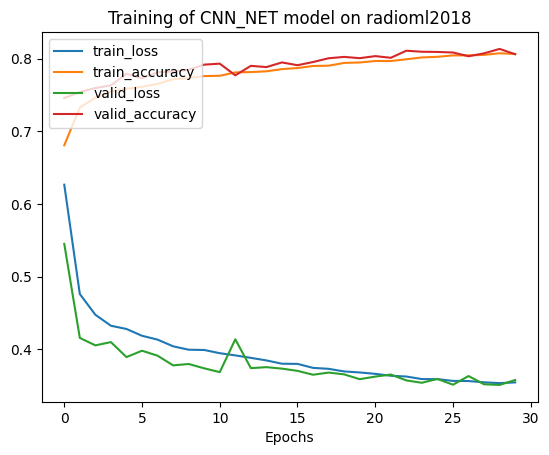

Accuracy on test dataset :80.76%.


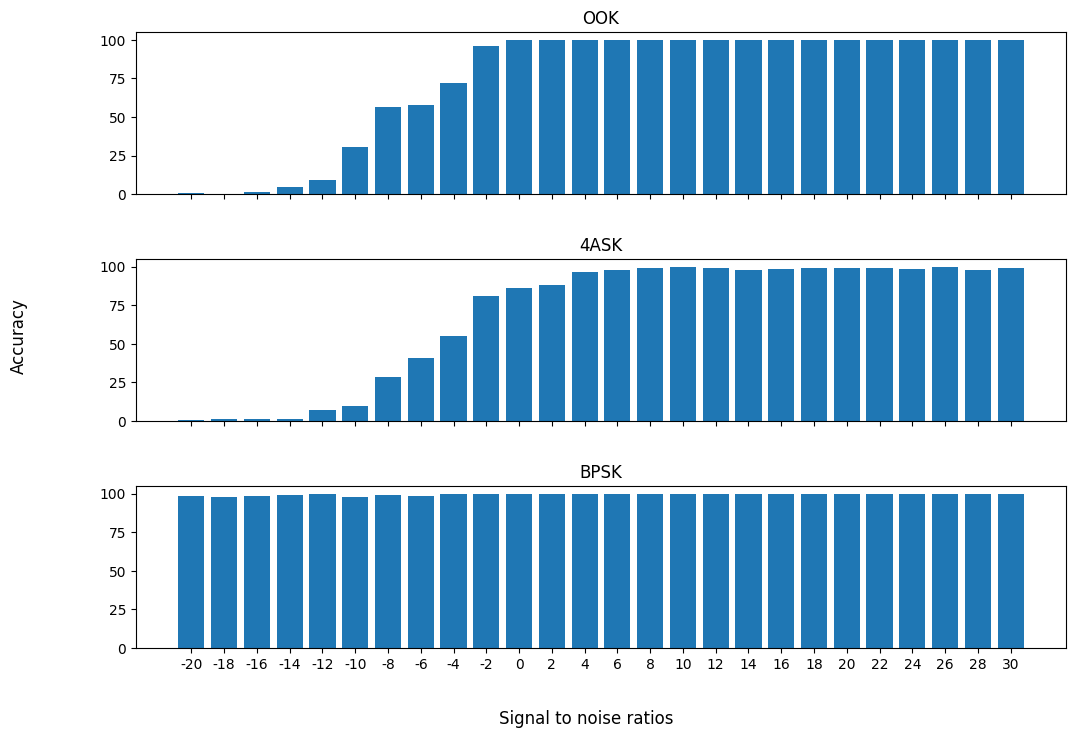

In [15]:
 train_test_plots(CNN_NET(),'CNN_NET',verbose=True)

In [77]:
class LSTMModel(nn.Module):
    def __init__(self,):
        super(LSTMModel, self).__init__()
#         self.encoder =nn.Sequential(
#             CNN_Block(2,64),
#             CNN_Block(64,128)
#         )
        self.lstm = nn.LSTM(2, 128, 3, batch_first=True) 


        self.fc = nn.Sequential(
            nn.Linear(128,128),
            nn.ReLU(),  
            nn.Linear(128,n_labels),
        )
        
    def forward(self, x):
#         x = self.encoder(x)

        out, (hn, cn) = self.lstm(x.transpose(1,2))

        out = self.fc(hn[-1])
        return out

In [78]:
summary(LSTMModel().to('cpu'), (batch_size,n_channels, frame_size))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [32, 3]                   --
├─LSTM: 1-1                              [32, 1024, 128]           331,776
├─Sequential: 1-2                        [32, 3]                   --
│    └─Linear: 2-1                       [32, 128]                 16,512
│    └─ReLU: 2-2                         [32, 128]                 --
│    └─Linear: 2-3                       [32, 3]                   387
Total params: 348,675
Trainable params: 348,675
Non-trainable params: 0
Total mult-adds (G): 10.87
Input size (MB): 0.26
Forward/backward pass size (MB): 33.59
Params size (MB): 1.39
Estimated Total Size (MB): 35.24

  0%|          | 0/30 [00:00<?, ?epochs/s]

Epoch 0 (train) -- loss: 1.0216 accuracy: 0.4325
Epoch 0 (valid) -- loss: 1.0963 accuracy: 0.3701
Epoch 1 (train) -- loss: 1.0883 accuracy: 0.3789
Epoch 1 (valid) -- loss: 1.0859 accuracy: 0.3847
Epoch 2 (train) -- loss: 1.0934 accuracy: 0.3668
Epoch 2 (valid) -- loss: 1.0946 accuracy: 0.3557
Epoch 3 (train) -- loss: 1.0933 accuracy: 0.3581
Epoch 3 (valid) -- loss: 1.0938 accuracy: 0.3562
Epoch 4 (train) -- loss: 1.0351 accuracy: 0.4147
Epoch 4 (valid) -- loss: 0.8986 accuracy: 0.5440
Epoch 5 (train) -- loss: 0.9516 accuracy: 0.4809
Epoch 5 (valid) -- loss: 0.8685 accuracy: 0.5111
Epoch 6 (train) -- loss: 0.7114 accuracy: 0.6074
Epoch 6 (valid) -- loss: 0.6490 accuracy: 0.6324
Epoch 7 (train) -- loss: 0.5763 accuracy: 0.6866
Epoch 7 (valid) -- loss: 0.5481 accuracy: 0.7039
Epoch 8 (train) -- loss: 0.5061 accuracy: 0.7385
Epoch 8 (valid) -- loss: 0.6206 accuracy: 0.7068
Epoch 9 (train) -- loss: 0.4483 accuracy: 0.7677
Epoch 9 (valid) -- loss: 0.4241 accuracy: 0.7815
Epoch 10 (train) -- 

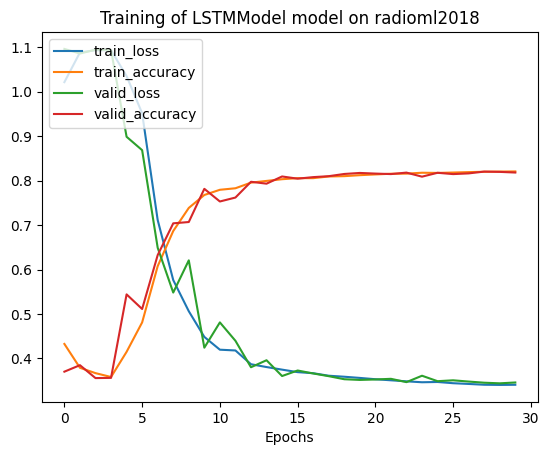

Accuracy on test dataset :81.68%.


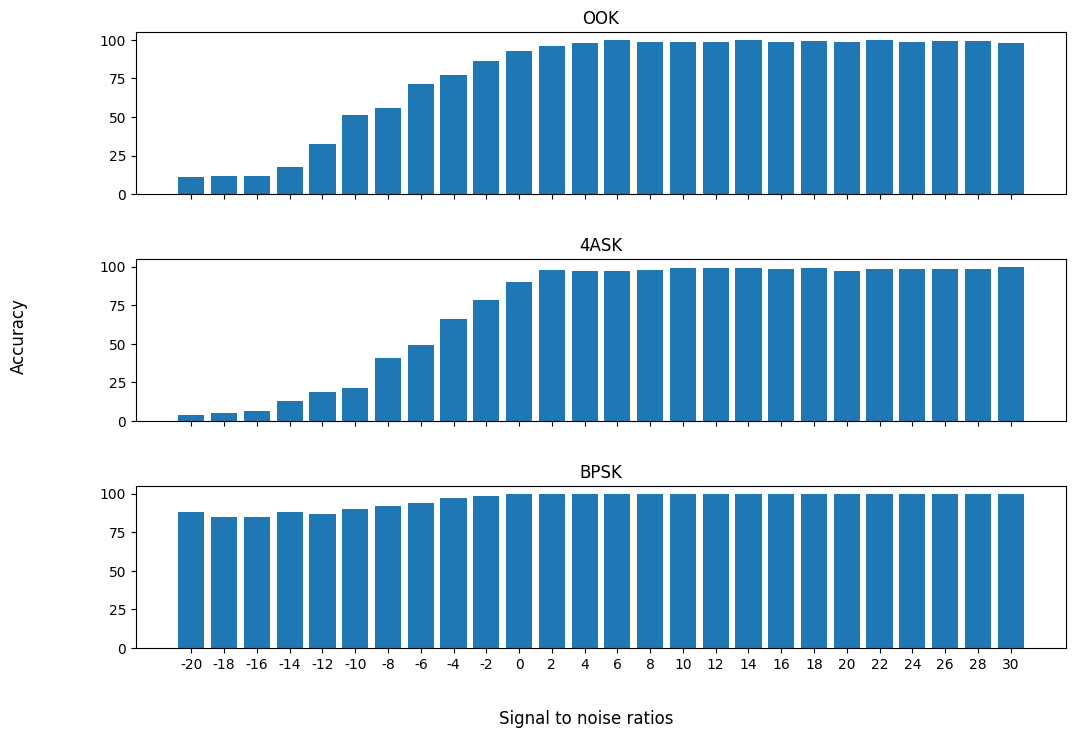

In [79]:
 train_test_plots(LSTMModel(),'LSTMModel',verbose=True)

In [208]:
class Residual_Unit(nn.Module):
    def __init__(self, input_shape,output_shape):
        super(Residual_Unit, self).__init__()
        self.net=nn.Sequential(
            nn.Conv1d(input_shape, output_shape, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(output_shape, output_shape, kernel_size=3, padding=1),
            nn.BatchNorm1d(output_shape),
        )
        self.skip= nn.Conv1d(input_shape, output_shape, kernel_size=1)
        self.activation= nn.ReLU()
    def forward(self, x):
 
        out = self.activation(self.skip(x)+self.skip(x))
        return out
    
class Residual_Stack(nn.Module):
    def __init__(self, input_shape,output_shape ):
        super(Residual_Stack, self).__init__()
        self.net=nn.Sequential(
            nn.Conv1d(input_shape, output_shape, kernel_size=1),
            Residual_Unit(output_shape,output_shape),
            Residual_Unit(output_shape,output_shape),
            nn.MaxPool1d(kernel_size= 2, stride= 2),
        )
    def forward(self, x):
        out = self.net(x)
        return out
    
class Residual_NET(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(Residual_NET, self).__init__()
        self.backbone = nn.Sequential(
            Residual_Stack(input_shape,output_shape),
            Residual_Stack(output_shape,output_shape),
            Residual_Stack(output_shape,output_shape),
            Residual_Stack(output_shape,output_shape),
            Residual_Stack(output_shape,output_shape),
            Residual_Stack(output_shape,output_shape),            
        )
        self.head =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(512,128),
            nn.SELU(),
            nn.Dropout(0.2),
            nn.Linear(128,128),
            nn.SELU(),
            nn.Dropout(0.2),
            nn.Linear(128,n_labels),
        )
    def forward(self, x):
        out = self.backbone(x)
        out = self.head(out)
        return out

In [210]:
summary(Residual_NET(2,32).to('cpu'), (batch_size,n_channels, frame_size))

Layer (type:depth-idx)                   Output Shape              Param #
Residual_NET                             [32, 3]                   --
├─Sequential: 1-1                        [32, 32, 16]              --
│    └─Residual_Stack: 2-1               [32, 32, 512]             --
│    │    └─Sequential: 3-1              [32, 32, 512]             14,752
│    └─Residual_Stack: 2-2               [32, 32, 256]             --
│    │    └─Sequential: 3-2              [32, 32, 256]             15,712
│    └─Residual_Stack: 2-3               [32, 32, 128]             --
│    │    └─Sequential: 3-3              [32, 32, 128]             15,712
│    └─Residual_Stack: 2-4               [32, 32, 64]              --
│    │    └─Sequential: 3-4              [32, 32, 64]              15,712
│    └─Residual_Stack: 2-5               [32, 32, 32]              --
│    │    └─Sequential: 3-5              [32, 32, 32]              15,712
│    └─Residual_Stack: 2-6               [32, 32, 16]            

  0%|          | 0/30 [00:00<?, ?epochs/s]

Epoch 0 (train) -- loss: 0.5995 accuracy: 0.6805
Epoch 0 (valid) -- loss: 0.4789 accuracy: 0.7362
Epoch 1 (train) -- loss: 0.4582 accuracy: 0.7493
Epoch 1 (valid) -- loss: 0.4325 accuracy: 0.7653
Epoch 2 (train) -- loss: 0.4452 accuracy: 0.7543
Epoch 2 (valid) -- loss: 0.4342 accuracy: 0.7578
Epoch 3 (train) -- loss: 0.4329 accuracy: 0.7602
Epoch 3 (valid) -- loss: 0.4283 accuracy: 0.7572
Epoch 4 (train) -- loss: 0.4275 accuracy: 0.7608
Epoch 4 (valid) -- loss: 0.4306 accuracy: 0.7603
Epoch 5 (train) -- loss: 0.4226 accuracy: 0.7646
Epoch 5 (valid) -- loss: 0.4061 accuracy: 0.7729
Epoch 6 (train) -- loss: 0.4106 accuracy: 0.7705
Epoch 6 (valid) -- loss: 0.4184 accuracy: 0.7729
Epoch 7 (train) -- loss: 0.4079 accuracy: 0.7725
Epoch 7 (valid) -- loss: 0.3972 accuracy: 0.7768
Epoch 8 (train) -- loss: 0.4065 accuracy: 0.7743
Epoch 8 (valid) -- loss: 0.4073 accuracy: 0.7727
Epoch 9 (train) -- loss: 0.4003 accuracy: 0.7764
Epoch 9 (valid) -- loss: 0.4130 accuracy: 0.7712
Epoch 10 (train) -- 

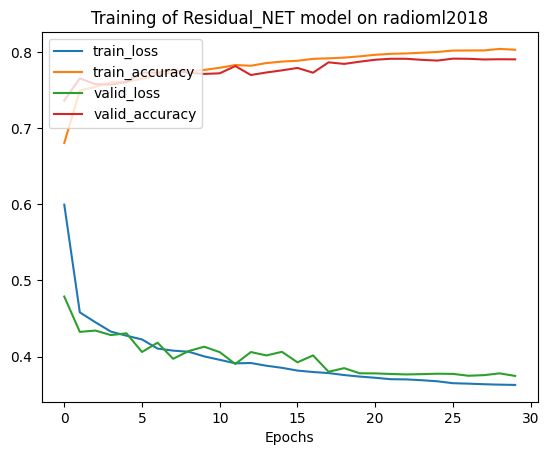

Accuracy on test dataset :78.92%.


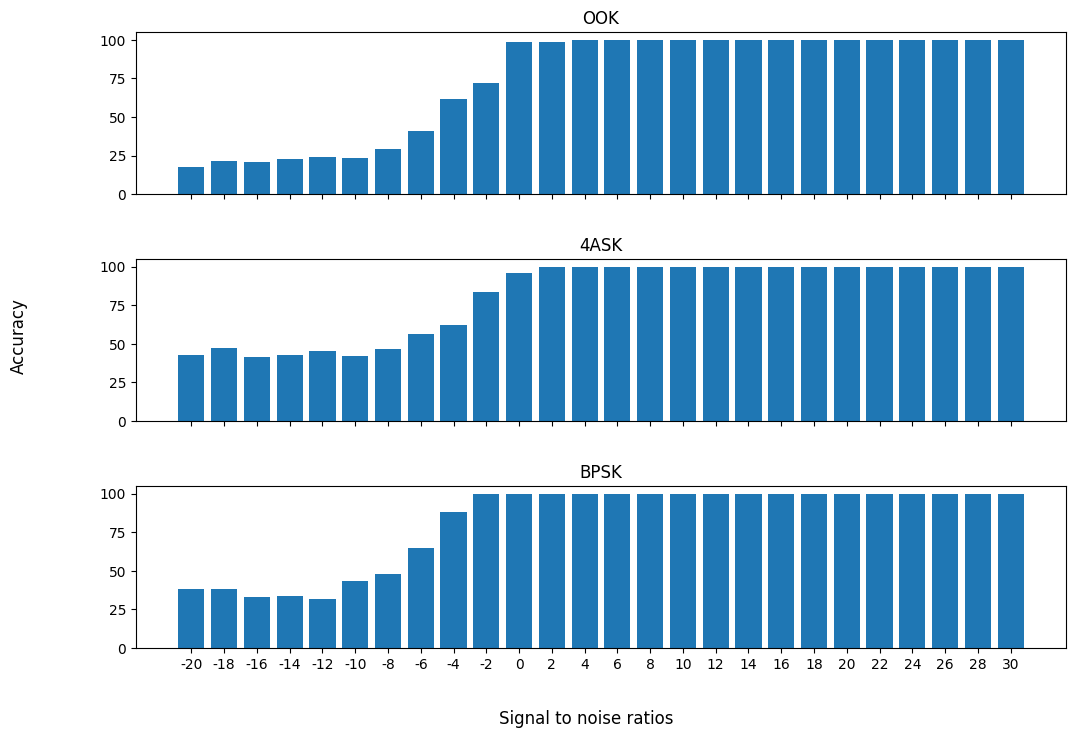

In [211]:
train_test_plots(Residual_NET(2,32),'Residual_NET',verbose=True)

In [258]:
class GRUModel(nn.Module):
    def __init__(self,):
        super(GRUModel, self).__init__()
        
        self.GRU = nn.GRU(2, 128, 4)

        self.fc = nn.Sequential(
            nn.Linear(128,128),
            nn.ReLU(),  
            nn.Linear(128,n_labels),
        )
        
    def forward(self, x):
        out, hn = self.GRU(x.transpose(1,2))
        out = self.fc(out[:,-1,:])
        return out

In [259]:
summary(GRUModel().to('cpu'), (batch_size,n_channels, frame_size))

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [32, 3]                   --
├─GRU: 1-1                               [32, 1024, 128]           347,904
├─Sequential: 1-2                        [32, 3]                   --
│    └─Linear: 2-1                       [32, 128]                 16,512
│    └─ReLU: 2-2                         [32, 128]                 --
│    └─Linear: 2-3                       [32, 3]                   387
Total params: 364,803
Trainable params: 364,803
Non-trainable params: 0
Total mult-adds (G): 11.40
Input size (MB): 0.26
Forward/backward pass size (MB): 33.59
Params size (MB): 1.46
Estimated Total Size (MB): 35.31

  0%|          | 0/30 [00:00<?, ?epochs/s]

Epoch 0 (train) -- loss: 1.0968 accuracy: 0.3394
Epoch 0 (valid) -- loss: 1.0869 accuracy: 0.3609
Epoch 1 (train) -- loss: 1.0469 accuracy: 0.4177
Epoch 1 (valid) -- loss: 1.0328 accuracy: 0.4277
Epoch 2 (train) -- loss: 1.0310 accuracy: 0.4408
Epoch 2 (valid) -- loss: 1.0298 accuracy: 0.4368
Epoch 3 (train) -- loss: 1.0271 accuracy: 0.4485
Epoch 3 (valid) -- loss: 1.0301 accuracy: 0.4496
Epoch 4 (train) -- loss: 1.0265 accuracy: 0.4479
Epoch 4 (valid) -- loss: 1.0265 accuracy: 0.4529
Epoch 5 (train) -- loss: 1.0251 accuracy: 0.4497
Epoch 5 (valid) -- loss: 1.0279 accuracy: 0.4448
Epoch 6 (train) -- loss: 1.0244 accuracy: 0.4503
Epoch 6 (valid) -- loss: 1.0235 accuracy: 0.4532
Epoch 7 (train) -- loss: 1.0235 accuracy: 0.4530
Epoch 7 (valid) -- loss: 1.0199 accuracy: 0.4548
Epoch 8 (train) -- loss: 1.0233 accuracy: 0.4533
Epoch 8 (valid) -- loss: 1.0242 accuracy: 0.4491
Epoch 9 (train) -- loss: 1.0225 accuracy: 0.4529
Epoch 9 (valid) -- loss: 1.0218 accuracy: 0.4583
Epoch 10 (train) -- 

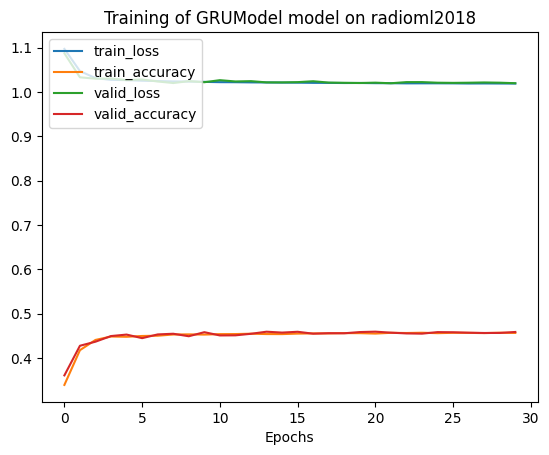

Accuracy on test dataset :45.44%.


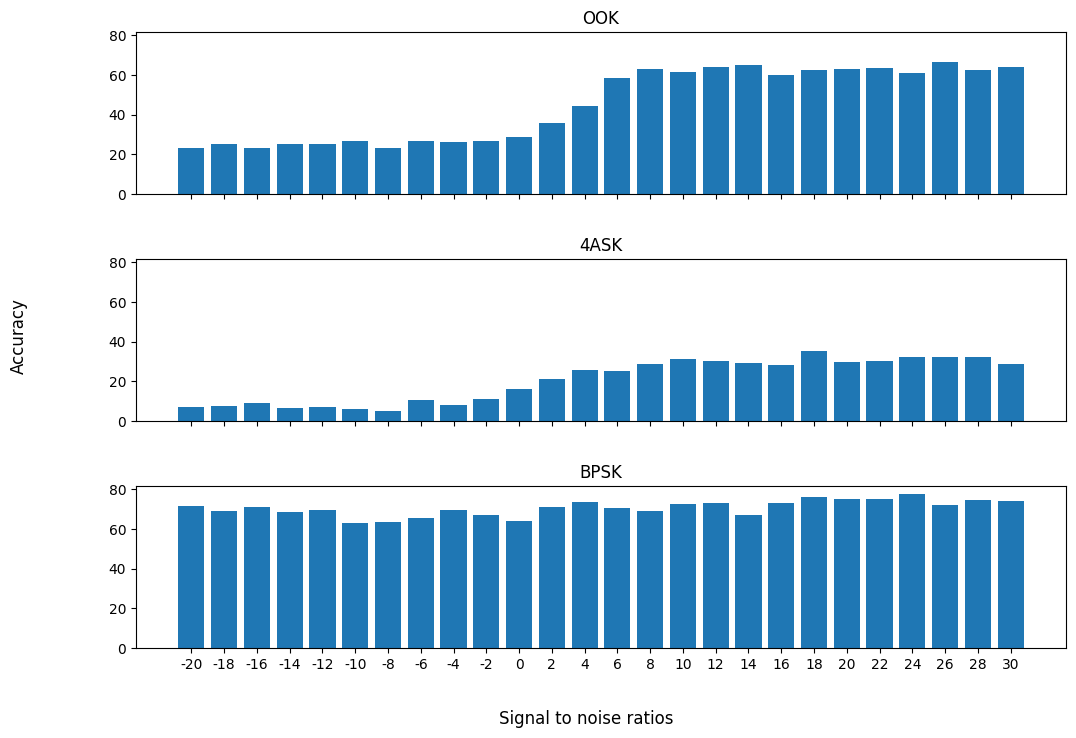

In [260]:
train_test_plots(GRUModel(),'GRUModel',verbose=True)

In [251]:
class LSTMGRUModel(nn.Module):
    def __init__(self,):
        super(LSTMGRUModel, self).__init__()

        self.lstm = nn.LSTM(2, 128, 2, batch_first=True)

        self.gru = nn.GRU(128, 128, 2, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_labels)
        )

    def forward(self, x):

        lstm_out, _ = self.lstm(x.transpose(1,2))

        gru_out, _ = self.gru(lstm_out)

        out = gru_out[:, -1, :]

        out = self.fc(out)

        return out

In [252]:
summary(LSTMGRUModel().to('cpu'), (batch_size,n_channels, frame_size))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMGRUModel                             [32, 3]                   --
├─LSTM: 1-1                              [32, 1024, 128]           199,680
├─GRU: 1-2                               [32, 1024, 128]           198,144
├─Sequential: 1-3                        [32, 3]                   --
│    └─Linear: 2-1                       [32, 128]                 16,512
│    └─ReLU: 2-2                         [32, 128]                 --
│    └─Linear: 2-3                       [32, 3]                   387
Total params: 414,723
Trainable params: 414,723
Non-trainable params: 0
Total mult-adds (G): 13.04
Input size (MB): 0.26
Forward/backward pass size (MB): 67.14
Params size (MB): 1.66
Estimated Total Size (MB): 69.06

  0%|          | 0/30 [00:00<?, ?epochs/s]

Epoch 0 (train) -- loss: 1.0171 accuracy: 0.4413
Epoch 0 (valid) -- loss: 1.0225 accuracy: 0.4277
Epoch 1 (train) -- loss: 1.0380 accuracy: 0.4135
Epoch 1 (valid) -- loss: 1.0192 accuracy: 0.4311
Epoch 2 (train) -- loss: 1.0318 accuracy: 0.4162
Epoch 2 (valid) -- loss: 1.0188 accuracy: 0.4296
Epoch 3 (train) -- loss: 0.9677 accuracy: 0.4800
Epoch 3 (valid) -- loss: 0.9138 accuracy: 0.5093
Epoch 4 (train) -- loss: 0.8580 accuracy: 0.5563
Epoch 4 (valid) -- loss: 0.7288 accuracy: 0.6416
Epoch 5 (train) -- loss: 0.5215 accuracy: 0.7201
Epoch 5 (valid) -- loss: 0.5410 accuracy: 0.6956
Epoch 6 (train) -- loss: 0.4476 accuracy: 0.7568
Epoch 6 (valid) -- loss: 0.3997 accuracy: 0.7870
Epoch 7 (train) -- loss: 0.3849 accuracy: 0.7957
Epoch 7 (valid) -- loss: 0.3572 accuracy: 0.8118
Epoch 8 (train) -- loss: 0.3701 accuracy: 0.8036
Epoch 8 (valid) -- loss: 0.3629 accuracy: 0.8092
Epoch 9 (train) -- loss: 0.3323 accuracy: 0.8247
Epoch 9 (valid) -- loss: 0.3335 accuracy: 0.8215
Epoch 10 (train) -- 

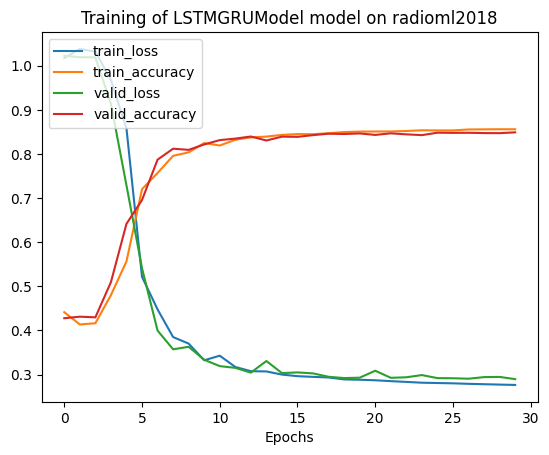

Accuracy on test dataset :84.84%.


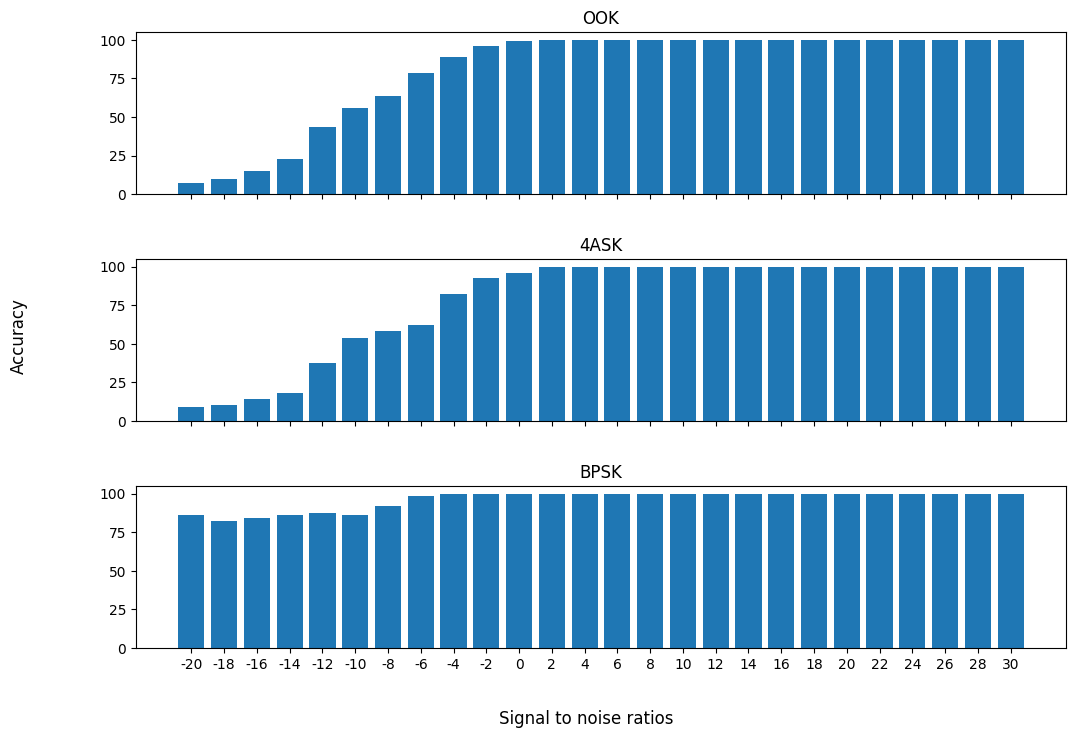

In [255]:
train_test_plots(LSTMGRUModel(),'LSTMGRUModel',verbose=True)

In [265]:
import time
st = time.time()
while True:
    if time.time()-st>900:
        break

In [326]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

class TransformerModel(nn.Module):

    def __init__(self, dropout: float = 0.3):
        super().__init__()
        self.model_type = 'Transformer'
        self.conv_backbone = nn.Sequential(
           nn.Conv1d(2,32,4,4),
           nn.BatchNorm1d(32),
           nn.LeakyReLU(),
           nn.Conv1d(32,64,4,4),
           nn.BatchNorm1d(64),
           nn.LeakyReLU(), 

        )
        self.pos_encoder = PositionalEncoding(64, dropout)
        encoder_layers = TransformerEncoderLayer(d_model=64,nhead=4,dim_feedforward=64,batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, 5)
        self.d_model =64
        self.linear = nn.Sequential(
        nn.Linear(64, 32),
        nn.Linear(32,n_labels)
        )

    def forward(self, src, src_mask= None):
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.conv_backbone(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = torch.mean(output,dim=1)
        output = self.linear(output)
        return output
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [327]:
summary(TransformerModel().to('cpu'), (batch_size,n_channels, frame_size))

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModel                              [32, 3]                   --
├─Sequential: 1-1                             [32, 64, 64]              --
│    └─Conv1d: 2-1                            [32, 32, 256]             288
│    └─BatchNorm1d: 2-2                       [32, 32, 256]             64
│    └─LeakyReLU: 2-3                         [32, 32, 256]             --
│    └─Conv1d: 2-4                            [32, 64, 64]              8,256
│    └─BatchNorm1d: 2-5                       [32, 64, 64]              128
│    └─LeakyReLU: 2-6                         [32, 64, 64]              --
├─PositionalEncoding: 1-2                     [32, 64, 64]              --
│    └─Dropout: 2-7                           [32, 64, 64]              --
├─TransformerEncoder: 1-3                     [32, 64, 64]              --
│    └─ModuleList: 2-8                        --                        --
│    │    └─Tra

  0%|          | 0/30 [00:00<?, ?epochs/s]

Epoch 0 (train) -- loss: 0.5885 accuracy: 0.6971
Epoch 0 (valid) -- loss: 0.5301 accuracy: 0.7172
Epoch 1 (train) -- loss: 0.4901 accuracy: 0.7494
Epoch 1 (valid) -- loss: 0.5320 accuracy: 0.7261
Epoch 2 (train) -- loss: 0.4700 accuracy: 0.7590
Epoch 2 (valid) -- loss: 0.5540 accuracy: 0.7033
Epoch 3 (train) -- loss: 0.4473 accuracy: 0.7703
Epoch 3 (valid) -- loss: 0.5624 accuracy: 0.6899
Epoch 4 (train) -- loss: 0.4346 accuracy: 0.7761
Epoch 4 (valid) -- loss: 0.7425 accuracy: 0.7018
Epoch 5 (train) -- loss: 0.4299 accuracy: 0.7783
Epoch 5 (valid) -- loss: 0.5239 accuracy: 0.7231
Epoch 6 (train) -- loss: 0.4276 accuracy: 0.7804
Epoch 6 (valid) -- loss: 0.5345 accuracy: 0.7147
Epoch 7 (train) -- loss: 0.4180 accuracy: 0.7830
Epoch 7 (valid) -- loss: 0.5130 accuracy: 0.7406
Epoch 8 (train) -- loss: 0.4167 accuracy: 0.7827
Epoch 8 (valid) -- loss: 0.5471 accuracy: 0.7280
Epoch 9 (train) -- loss: 0.4072 accuracy: 0.7878
Epoch 9 (valid) -- loss: 0.5199 accuracy: 0.7320
Epoch 10 (train) -- 

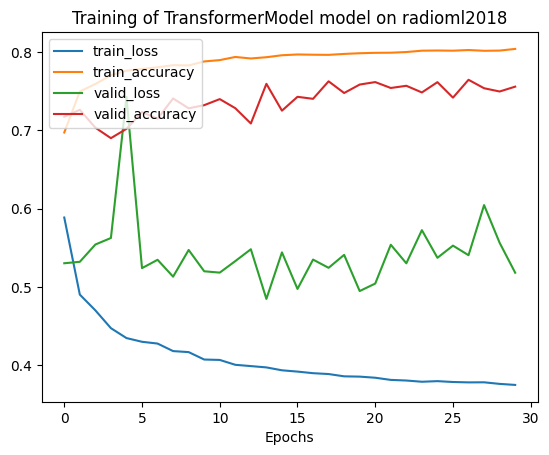

Accuracy on test dataset :75.47%.


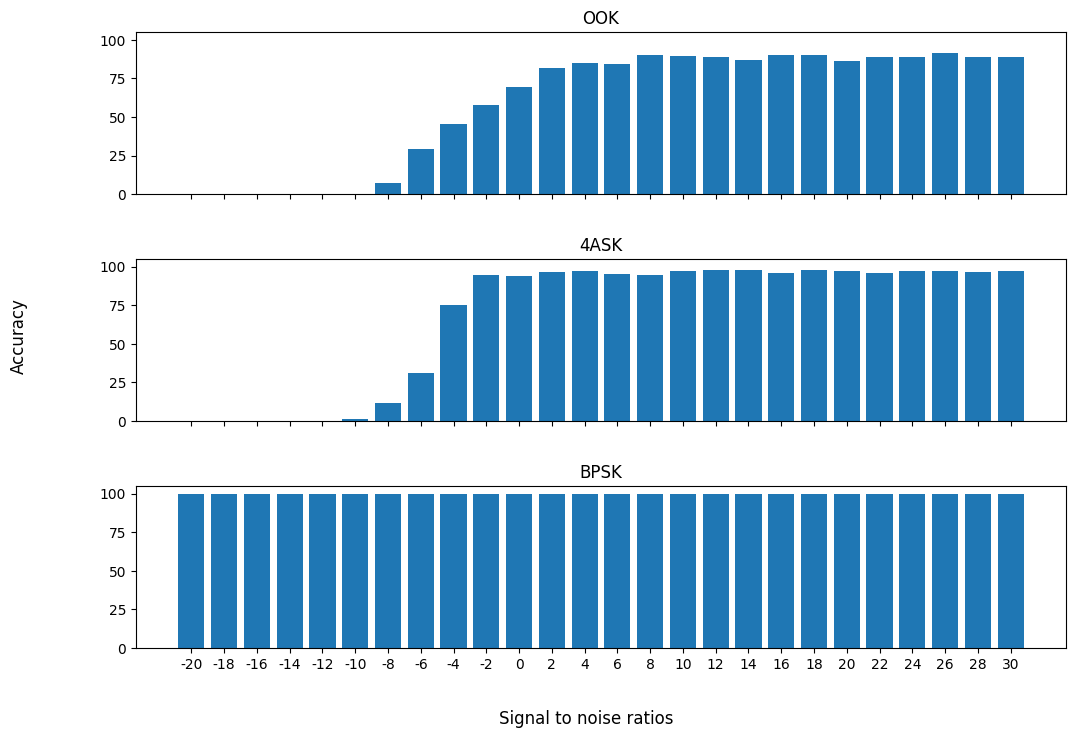

In [328]:
train_test_plots(TransformerModel(),'TransformerModel',verbose=True)